In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
basedir = "/pscratch/sd/h/hebina/AbacusLBG/"
import sys, os
from astropy.table import Table, vstack
from astropy.io import fits

for subdir in ["",'ibis_tertiary44/LAE_auto_v2']:
    sys.path.append(basedir+subdir)
from misc import *
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import json
from scipy.special     import erfc

sys.path.append('..')
from mc_forecast import mc_forecast
from forecast_utils import *

sys.path.append('/pscratch/sd/h/hebina/AbacusLBG')
from calc_wt import *
from calc_wx import *
from calc_xi import *
from wtheta_xi import *


In [4]:
from matplotlib.pyplot import rc
rc('mathtext', **{'fontset':'cm'})
import matplotlib
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams["font.family"] = "serif"


In [5]:
m_bands = ['M411','M438','M464','M490','M517']
band_z = {
    'M411':[2.26,2.56],
    'M438':[2.47,2.77],
    'M464':[2.68,2.98],
    'M490':[2.89,3.2],
    'M517':[3.1,3.41]
}
band_chimid = {'M411': 3945.5839397567484, 'M438': 4112.149560017418, 'M464': 4265.362496255113, 'M490': 4409.927293886262, 'M517': 4540.894419987146}


In [6]:
cosmo = get_cosmo_P18()
h = cosmo.h()

In [7]:
rbins = np.geomspace(0.4,45,9)[1:]
RwR = np.sqrt(rbins[1:]*rbins[:-1])


In [8]:
fint_list = np.loadtxt('/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/fint_v4/pessimistic.txt')
fint_list += np.loadtxt('/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/fint_v4/optimistic.txt')
fint_list /= 2

fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/wR_v4/lae_5bins.json'
data = json.load(open(fn,'r'))

datwt_array = []
for j, band in enumerate(m_bands):
    fint = fint_list[j]    
    datwt_array.append(np.array(data['z%d'%(j+1)]['wt']) / (1-fint)**2)
datwt_array = np.array(datwt_array)

In [9]:
fn = "/pscratch/sd/h/hebina/IBIS/selection_clustering/catalogs/clustering_cat_v4.fits"
# fn = "/global/cfs/cdirs/desi/users/raichoor/laelbg/ibis/analysis/daily-tmp/ibis-xmm-ar-djs-he-rr.fits"
d = Table.read(fn)
radius = 1.4
ra0,dec0 = 35.75, -4.75
area = 1.4**2 * np.pi
coord_cut = angular_distance(d['RA'],d['DEC'],ra0,dec0)<radius
d = d[coord_cut]

fn = "/pscratch/sd/h/hebina/IBIS/selection_clustering/catalogs/redshift_cat_v4.fits"
# fn = "/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto/ibis-xmm-ar-djs-he-rr.fits"
d_spec = Table.read(fn)
radius = 1.4
ra0,dec0 = 35.75, -4.75
area = 1.4**2 * np.pi
coord_cut = angular_distance(d_spec['RA'],d_spec['DEC'],ra0,dec0)<radius
d_spec = d_spec[coord_cut]

In [10]:
use_mask = True

# $\chi^2$ fits

In [11]:
rbins = np.geomspace(0.4,45,9)[:-1]
RwR = np.sqrt(rbins[1:]*rbins[:-1])
lgMc_list = [11.00,11.25,11.50,11.75,12.0,12.25,12.5]
alph_list = [.33,.5,.66]#,1.]
sigm_list = [.33,.5,.66]#,1.]
kapp_list = [1]
plat_list = [5,10]

chi2_arr = []
hod_arr = []
for lgMcut in lgMc_list:
  for plateau in plat_list:
    lgM1 = lgMcut + np.log10(plateau)
    for alph in alph_list:
      for sigm in sigm_list:
        for kappa in kapp_list:
          # hod_params = {'logM_cut':11.75,'logM1':12.45,'sigma':0.66,'kappa':1.00,'alpha':1.0}
          hod_params = {'logM_cut':lgMcut,'logM1':lgM1,'sigma':sigm,'kappa':kappa,'alpha':alph}      
          forecast = mc_forecast.initialize('ibis_tertiary44_clustering_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                                   band_z['M411'][0], band_z['M517'][1], hod_params, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                                   m_bands=['M411','M438'],zbox=2.5)
          assert forecast.check_hod_exists()
          # forecast.make_cat(overwrite=False)
          # forecast.compute_wR(overwrite=False)
          c2, tmp1, tmp2, _ = forecast.chi2_wR(datwt_array[:2])
          hod_arr.append(hod_params)
          chi2_arr.append(c2)
#           plt.plot(RwR,RwR*tmp1,'o-')
#           plt.plot(RwR,RwR*tmp2,'k.--')
# plt.xscale('log')
# plt.show()       


7.3585499803066226
{'logM_cut': 11.25, 'logM1': 11.948970004336019, 'sigma': 0.66, 'kappa': 1, 'alpha': 0.33}


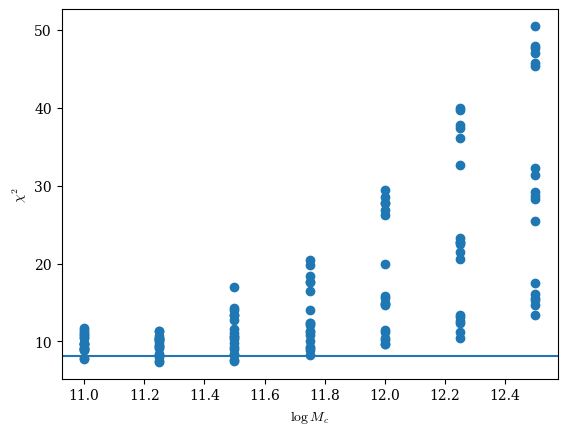

In [12]:
plt.scatter([ss['logM_cut'] for ss in hod_arr],chi2_arr)
print(np.min(chi2_arr))
print(hod_arr[np.argmin(chi2_arr)])
plt.axhline(8.18)
plt.ylabel(r'$\chi^2$')
plt.xlabel(r'$\log M_c$')
# plt.ylim(2.9,3.0)
# chi2(k=7)	8.18	9.80	12.02	14.07	14.34	18.48	21.85	24.32	30.96
plt.show()

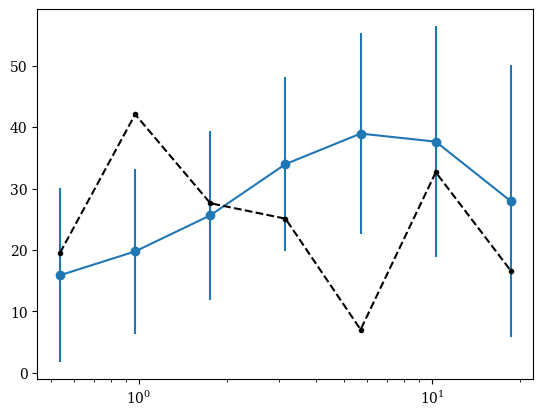

In [13]:
hod_z1 = hod_arr[np.argmin(chi2_arr)]
chi2_z1 = np.min(chi2_arr)
forecast = mc_forecast.initialize('ibis_tertiary44_clustering_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                       band_z['M411'][0], band_z['M517'][1], hod_z1, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                       m_bands=['M411','M438'],zbox=2.5)
c2, dd_z1, ss_z1, cov_z1 = forecast.chi2_wR(datwt_array[:2])
plt.errorbar(RwR,RwR*dd_z1,fmt='o-',yerr=RwR*np.sqrt(np.diag(cov_z1)))
plt.errorbar(RwR,RwR*ss_z1,fmt='k.--')
plt.xscale('log')
plt.show()       
# print(np.einsum(dd-ss)


In [14]:
rbins = np.geomspace(0.4,45,9)[:-1]
RwR = np.sqrt(rbins[1:]*rbins[:-1])
lgMc_list = [11.00,11.25,11.50,11.75,12.0,12.25,12.5]
alph_list = [.33,.5,.66]#,1.]
sigm_list = [.33,.5,.66]#,1.]
kapp_list = [1]
plat_list = [5,10]
chi2_arr = []
hod_arr = []
for lgMcut in lgMc_list:
  for plateau in plat_list:
    lgM1 = lgMcut + np.log10(plateau)
    for alph in alph_list:
      for sigm in sigm_list:
        for kappa in kapp_list:
          # hod_params = {'logM_cut':11.75,'logM1':12.45,'sigma':0.66,'kappa':1.00,'alpha':1.0}
          hod_params = {'logM_cut':lgMcut,'logM1':lgM1,'sigma':sigm,'kappa':kappa,'alpha':alph}      
          forecast = mc_forecast.initialize('ibis_tertiary44_clustering_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                                   band_z['M411'][0], band_z['M517'][1], hod_params, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                                   m_bands=['M464','M490','M517'],zbox=3.0)
          assert forecast.check_hod_exists()
          # forecast.make_cat(overwrite=False)
          # forecast.compute_wR(overwrite=False)
          c2, tmp1, tmp2, _ = forecast.chi2_wR(datwt_array[2:])
          hod_arr.append(hod_params)
          chi2_arr.append(c2)
#           plt.plot(RwR,RwR*tmp1,'o-')
#           plt.plot(RwR,RwR*tmp2,'k.--')
# plt.xscale('log')
# plt.show()       


7.222328914433106
{'logM_cut': 12.0, 'logM1': 12.698970004336019, 'sigma': 0.66, 'kappa': 1, 'alpha': 0.5}


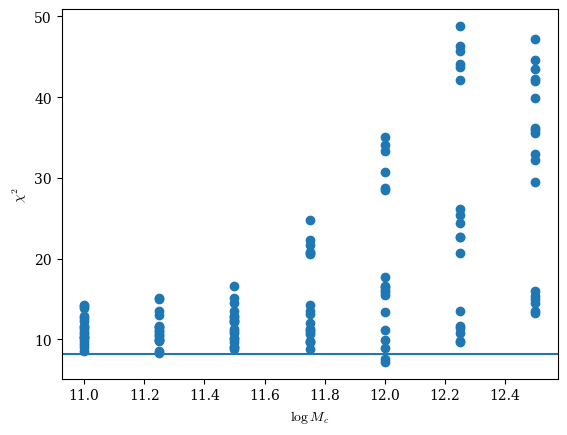

In [15]:
plt.scatter([ss['logM_cut'] for ss in hod_arr],chi2_arr)
print(np.min(chi2_arr))
print(hod_arr[np.argmin(chi2_arr)])
plt.axhline(8.18)
plt.ylabel(r'$\chi^2$')
plt.xlabel(r'$\log M_c$')

plt.show()

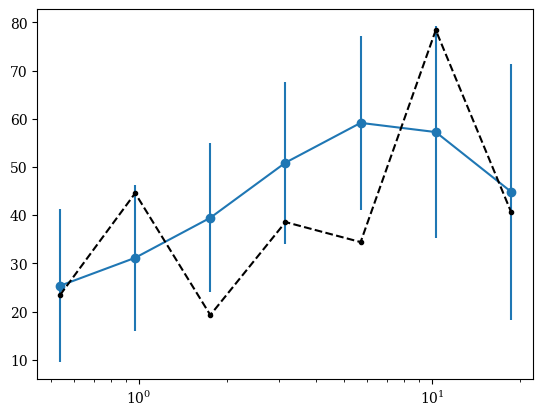

In [16]:
hod_z2 = hod_arr[np.argmin(chi2_arr)]
chi2_z2 = np.min(chi2_arr)
forecast = mc_forecast.initialize('ibis_tertiary44_clustering_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                       band_z['M411'][0], band_z['M517'][1], hod_z2, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                       m_bands=['M464','M490','M517'],zbox=3.0)
c2, dd_z2, ss_z2, cov_z2 = forecast.chi2_wR(datwt_array[2:])
plt.errorbar(RwR,RwR*dd_z2,fmt='o-',yerr=RwR*np.sqrt(np.diag(cov_z2)))
plt.errorbar(RwR,RwR*ss_z2,fmt='k.--')
plt.xscale('log')
plt.show()       
# print(np.einsum(dd-ss)


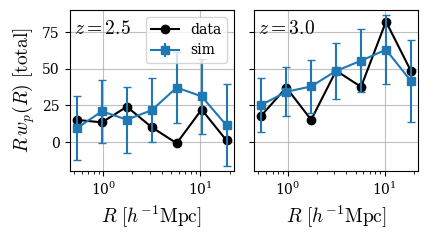

In [43]:
# fig, axs = plt.subplots(1,2,figsize=(6,2.5))
fig, axs = plt.subplots(1,2,figsize=(4.5,2.5))

for i, (ax, dd, ss, cov) in enumerate(zip(axs,[dd_z1,dd_z2],[ss_z1,ss_z2],[cov_z1,cov_z2])):
    ax.plot(RwR,RwR*ss,'ko-')
    ax.errorbar(RwR,RwR*dd,fmt='C0s-',yerr=RwR*np.sqrt(np.diag(cov)),capsize=3)
    ax.set_xscale('log')
    ax.grid(alpha=.8)
    ax.set_xlabel(r'$R\,\,[h^{-1}\text{Mpc}]$',fontsize=14)
    ax.set_ylim(-20,90)
    if i==0: 
        ax.plot([],[],'ko-',label='data')
        ax.errorbar([],[],fmt='C0s-',yerr=[],capsize=3,label='sim')
        ax.legend(loc='upper right')
        ax.set_ylabel(r'$R\, w_p(R)\,\, [\text{total}]$',fontsize=14)
        ax.set_title(r'$z=2.5$',fontsize=14,x=.2, y=0.8)
    else: 
        ax.set_yticklabels([])
        ax.set_title(r'$z=3.0$',fontsize=14,x=.2, y=0.8)
fig.tight_layout()
# fig.savefig('plots/wR_bestfit_total.pdf')
fig.show()

In [17]:
bestfit_dict = {'z1':{'z':2.5,
                      'data':ss_z1.tolist(),
                      'sim':dd_z1.tolist(),
                      'cov':cov_z1.tolist(),
                      'hod':hod_z1,
                      'chi2':chi2_z1,
                     },
                'z2':{'z':3.0,
                      'data':ss_z2.tolist(),
                      'sim':dd_z2.tolist(),
                      'cov':cov_z2.tolist(),
                      'hod':hod_z2,
                      'chi2':chi2_z2,
                     },
                'R':RwR.tolist(),
                'rbins':rbins.tolist(),
               }
import json
with open('bestfit.json', 'w') as fp:
    json.dump(bestfit_dict, fp)


0.007803121500083346 0.2695459191231433
0.0074870503665652255 0.2586277648701914
0.00721811355956978 0.2493377879261112
0.00698149171606127 0.24116407791884903
0.006780133608741026 0.2342084953215574


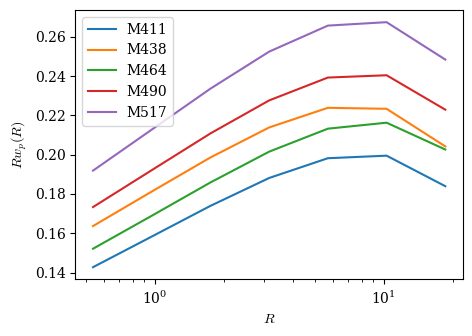

In [33]:
# suppose r0 = 3
fig, ax = plt.subplots(1,1,figsize=(5,3.5))
r0 = 3
gamma = 1.8
rr = np.geomspace(0.1,50)

wt_acc_band = []
theta_acc_band = []

for iband in range(5):
    if iband<2: zmid = 3.0 #2.5
    else: zmid=3.0

    tmp  = json.load(open('../AbacusSummit_high_c000_ph100/z%.1f/ibis_tertiary44_clustering_v4.2/logM_cut_11.25_logM1_12.25_sigma_0.33_kappa_1.00_alpha_0.33/configs.json'%zmid,'r'))
    
    # ax.plot(rr,rr*wp_true,label='truth')
    
    if iband<2: p_func = Spline(tmp['chi_vector'],np.array(tmp['dNdchi_band'][iband])/np.trapz(tmp['dNdchi_band'][iband],tmp['chi_vector']),ext='zeros')
    else: p_func = Spline(tmp['chi_vector'],np.array(tmp['dNdchi_band'][iband-2])/np.trapz(tmp['dNdchi_band'][iband-2],tmp['chi_vector']),ext='zeros')
    xi_func = Spline(rr,(r0/rr)**gamma,ext='zeros')
    theta = RwR * 180/np.pi / band_chimid[m_bands[iband]]
    print(np.min(theta),np.max(theta))
    wt_accurate = []    
    for tt in theta:
        wt_accurate.append(w_theta(tt*np.pi/180,p_func,xi_func,Npnt=750))
    wt_accurate = np.array(wt_accurate)
    wt_acc_band.append(wt_accurate)
    ax.plot(RwR,RwR*wt_accurate,label=m_bands[iband])
wt_acc_band = np.array(wt_acc_band)
ax.legend()
ax.set_xscale('log')
ax.set_xlabel(r'$R$')
ax.set_ylabel(r'$Rw_p(R)$')
plt.show()


In [35]:
f2_dict = json.load(open('/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/f2.json','r'))
# load bestfit HODs and use that to generate wp (with input wR (above)) 
total_bf = json.load(open('bestfit.json','r'))

wp_r0 = np.zeros((2,len(RwR))) # redshift, R 
chi2_r0 = np.zeros((2))

for i, bf_dict in enumerate([total_bf]): # sample
    tmp_hod = bf_dict['z1']['hod']
    forecast = mc_forecast.initialize('ibis_tertiary44_clustering_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                           band_z['M411'][0], band_z['M517'][1], tmp_hod, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                           m_bands=['M411','M438'],zbox=2.5)
    c2, _, mm, _ = forecast.chi2_wR(wt_acc_band[:2])
    wp_r0[0] = mm
    chi2_r0[0] = c2
    
    tmp_hod = bf_dict['z2']['hod']
    forecast = mc_forecast.initialize('ibis_tertiary44_clustering_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                           band_z['M411'][0], band_z['M517'][1], tmp_hod, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                           m_bands=['M464','M490','M517'],zbox=3.0)
    c2, _, mm, _ = forecast.chi2_wR(wt_acc_band[2:])
    wp_r0[1] = mm
    chi2_r0[1] = c2



In [37]:
bestfit_dict = {'3':{'wp':wp_r0.tolist(),
                     'chi2':chi2_r0.tolist(),
                     },
                # '3':{'wp':wp_r0.tolist()
                #      'chi2':chi2_r0.tolist(),
                #      },
                'R':RwR.tolist(),
               }
import json
with open('powerlaw_xi.json', 'w') as fp:
    json.dump(bestfit_dict, fp)


In [27]:
bestfit_dict['z1']['hod']

{'logM_cut': 11.5,
 'logM1': 12.198970004336019,
 'sigma': 0.66,
 'kappa': 1,
 'alpha': 0.66}

In [18]:
def wt_band_from_r0(r0):
    gamma = 1.8
    rr = np.geomspace(0.1,50)
    wt_acc_band = []
    for iband in range(5):
        if iband<2: zmid = 3.0 #2.5
        else: zmid=3.0
    
        tmp  = json.load(open('../AbacusSummit_high_c000_ph100/z%.1f/ibis_tertiary44_clustering_v4.1/logM_cut_11.25_logM1_12.25_sigma_0.33_kappa_1.00_alpha_0.33/configs.json'%zmid,'r'))
        
        # ax.plot(rr,rr*wp_true,label='truth')
        
        if iband<2: p_func = Spline(tmp['chi_vector'],np.array(tmp['dNdchi_band'][iband])/np.trapz(tmp['dNdchi_band'][iband],tmp['chi_vector']),ext='zeros')
        else: p_func = Spline(tmp['chi_vector'],np.array(tmp['dNdchi_band'][iband-2])/np.trapz(tmp['dNdchi_band'][iband-2],tmp['chi_vector']),ext='zeros')
        xi_func = Spline(rr,(r0/rr)**gamma,ext='zeros')
        theta = RwR * 180/np.pi / band_chimid[m_bands[iband]]
        wt_accurate = []    
        for tt in theta:
            wt_accurate.append(w_theta(tt*np.pi/180,p_func,xi_func,Npnt=750))
        wt_accurate = np.array(wt_accurate)
        wt_acc_band.append(wt_accurate)
    wt_acc_band = np.array(wt_acc_band)
    return wt_acc_band
power_dict = {}
for r0 in [2,3,4,5]:
    f2_dict = json.load(open('/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/f2.json','r'))
    # load bestfit HODs and use that to generate wp (with input wR (above)) 
    total_bf = json.load(open('bestfit.json','r'))
    
    wp_r0 = np.zeros((2,len(RwR))) # redshift, R 
    chi2_r0 = np.zeros((2))

    wt_acc_band = wt_band_from_r0(r0)
    for i, bf_dict in enumerate([total_bf]): # sample
        tmp_hod = bf_dict['z1']['hod']
        forecast = mc_forecast.initialize('ibis_tertiary44_clustering_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                               band_z['M411'][0], band_z['M517'][1], tmp_hod, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                               m_bands=['M411','M438'],zbox=2.5)
        c2, _, mm, _ = forecast.chi2_wR(wt_acc_band[:2])
        wp_r0[0] = mm
        chi2_r0[0] = c2
        
        tmp_hod = bf_dict['z2']['hod']
        forecast = mc_forecast.initialize('ibis_tertiary44_clustering_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                               band_z['M411'][0], band_z['M517'][1], tmp_hod, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                               m_bands=['M464','M490','M517'],zbox=3.0)
        c2, _, mm, _ = forecast.chi2_wR(wt_acc_band[2:])
        wp_r0[1] = mm
        chi2_r0[1] = c2
    power_dict['%d'%r0] = {'wp':wp_r0.tolist(),
                     'chi2':chi2_r0.tolist(),
                     }
    
import json
with open('powerlaw_xi.json', 'w') as fp:
    json.dump(power_dict, fp)



# Plot both samples

{'logM_cut': 11.25, 'logM1': 11.948970004336019, 'sigma': 0.66, 'kappa': 1, 'alpha': 0.33}
0 0 19.256544454198327
{'logM_cut': 12.0, 'logM1': 12.698970004336019, 'sigma': 0.66, 'kappa': 1, 'alpha': 0.5}
0 1 23.624250705562186
{'logM_cut': 11.0, 'logM1': 12.0, 'sigma': 0.66, 'kappa': 1, 'alpha': 0.5}
1 0 15.376120653366037
{'logM_cut': 11.75, 'logM1': 12.448970004336019, 'sigma': 0.66, 'kappa': 1, 'alpha': 0.33}
1 1 18.551468993447187


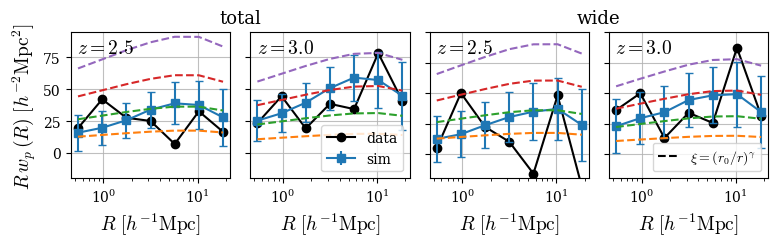

In [11]:
# call both of the best fit values and plot

total_bf = json.load(open('bestfit.json','r'))
bright_bf = json.load(open('../ibis_tertiary44_bright_v4.2/bestfit.json','r'))

total_powerlaw = json.load(open('powerlaw_xi.json','r'))
bright_powerlaw = json.load(open('../ibis_tertiary44_bright_v4.2/powerlaw_xi.json','r'))

fig, axs = plt.subplots(1,4,figsize=(8,2.5))
for i, bf_dict, pl_dict in zip(range(2),[total_bf,bright_bf],[total_powerlaw,bright_powerlaw]): # sample
    for j in range(2): # redshift
        ax = axs[i*2+j]
        RwR = np.array(bf_dict['R'])
        ss = np.array(bf_dict['z%d'%(j+1)]['data'])
        dd = np.array(bf_dict['z%d'%(j+1)]['sim'])
        cov = np.array(bf_dict['z%d'%(j+1)]['cov'])
        print(bf_dict['z%d'%(j+1)]['hod'])
        ax.plot(RwR,RwR*ss,'ko-')
        ax.errorbar(RwR,RwR*dd,fmt='C0s-',yerr=RwR*np.sqrt(np.diag(cov)),capsize=3)

        chi2 = np.einsum('i,ij,j',ss,np.linalg.inv(cov),ss)
        print(i,j,chi2)

        d_pl = np.array(pl_dict['2']['wp'])[j]
        ax.errorbar(RwR,RwR*d_pl,fmt='C1--',)
        d_pl = np.array(pl_dict['3']['wp'])[j]
        ax.errorbar(RwR,RwR*d_pl,fmt='C2--',)
        d_pl = np.array(pl_dict['4']['wp'])[j]
        ax.errorbar(RwR,RwR*d_pl,fmt='C3--',)
        d_pl = np.array(pl_dict['5']['wp'])[j]
        ax.errorbar(RwR,RwR*d_pl,fmt='C4--',)


        
        ax.set_xscale('log')
        ax.grid(alpha=.8)
        ax.set_xlabel(r'$R\,\,[h^{-1}\text{Mpc}]$',fontsize=14)
        if i==0: 
            # ax.set_ylim(-.05,.65)
            ax.set_ylim(-20,95)
        else:
            ax.set_ylim(-20,100)
        if j==0 and i==0:
            ax.set_ylabel(r'$R\,w_p\,(R)\,\,[h^{-2}\text{Mpc}^2]$',fontsize=14)
        elif i==0 and j==1: 
            ax.plot([],[],'ko-',label='data')
            ax.errorbar([],[],fmt='C0s-',yerr=[],capsize=3,label='sim')
            ax.legend(loc='lower right')
        elif i==1 and j==1: 
            ax.plot([],[],'k--',label=r'$\xi=(r_0/r)^\gamma$')
            ax.legend(loc='lower right',handlelength=1.5,ncol=1)
            # ax.plot([],[],'C1',label=r'$2$')
            # ax.plot([],[],'C2',label=r'$3$')
            # ax.plot([],[],'C3',label=r'$4$')
            # ax.plot([],[],'C4',label=r'$5$')
            # ax.legend(loc='lower right',handlelength=.5,title=r'$r_0$',ncol=2)
        else: 
            # ax.set_ylabel(r'$R\, \tilde{w}(R)\,\, [\text{bright}]$',fontsize=12)
            ax.set_yticklabels([])
        if j==0:
            ax.set_title(r'$z=2.5$',fontsize=14,x=.22, y=0.8)
        else: 
            ax.set_yticklabels([])
            ax.set_title(r'$z=3.0$',fontsize=14,x=.22, y=0.8)
fig.tight_layout(rect=[0, 0, 1, 0.94])   # <- reserve top 10 % of figure
for g, label in enumerate(['total', 'wide']):
    left  = axs[g*2    ].get_position()
    right = axs[g*2 + 1].get_position()
    xmid  = (left.x0 + right.x1) / 2          # centre of the pair
    ytop  = left.y1 + 0.02                    # a bit above the axes
    fig.text(xmid, ytop, label, ha='center', va='bottom',
             fontsize=13)
fig.savefig('plots/wR_bestfit_flat.pdf')
fig.show()

In [45]:
chi2_to_two_sided_sigmas(11.961962451411082,7), chi2_to_two_sided_sigmas(30.880594034099715,7)

(1.6361093042429886, 3.9924038582539025)

In [46]:
chi2_to_two_sided_sigmas(8.86572818961174,7), chi2_to_two_sided_sigmas(15.562163066704585,7)

(1.1206413402524826, 2.177654134050288)

# Plot data (with bestfit)

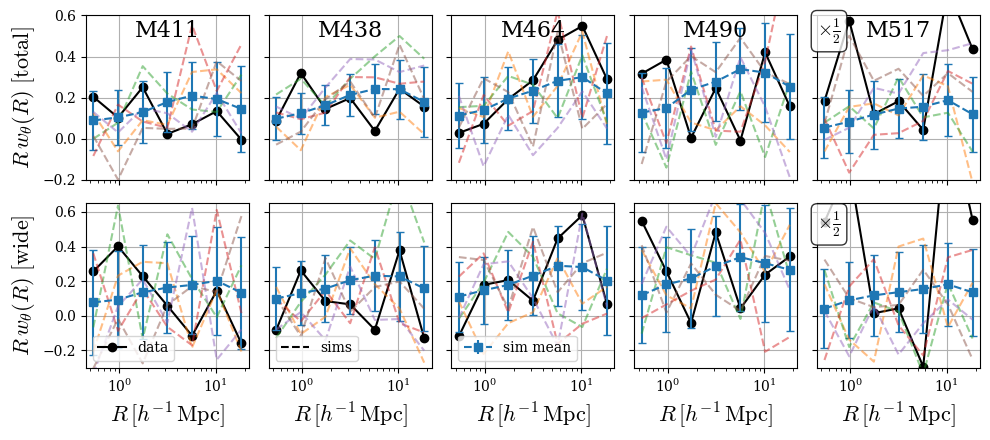

In [12]:
fig, axs = plt.subplots(2,5,figsize=(10,4.5))

total_bf = json.load(open('bestfit.json','r'))
bright_bf = json.load(open('../ibis_tertiary44_bright_v4/bestfit.json','r'))

fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/wR_v4/lae_5bins.json'
data = json.load(open(fn,'r'))
fint_list = np.loadtxt('/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/fint_v4/pessimistic.txt')
fint_list += np.loadtxt('/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/fint_v4/optimistic.txt')
fint_list /= 2

props = dict(boxstyle='round', facecolor='w', alpha=0.8)

for j, band in enumerate(m_bands):
    ax = axs[0,j]
    fint = fint_list[j]    
    datrr = np.array(data['r'])
    datwt = np.array(data['z%d'%(j+1)]['wt']) / (1-fint)**2
    if j<4: ax.plot(datrr,datrr*datwt,'o-',c='k',)
    else: ax.plot(datrr,0.5*datrr*datwt,'o-',c='k',)

    if j<2: fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/mc/AbacusSummit_high_c000_ph100/z2.5/ibis_tertiary44_clustering_v4.2/%s/clustering/wR_%s_summary.txt'%(get_hod_string(total_bf['z1']['hod']),band)
    else: fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/mc/AbacusSummit_high_c000_ph100/z3.0/ibis_tertiary44_clustering_v4.2/%s/clustering/wR_%s_summary.txt'%(get_hod_string(total_bf['z1']['hod']),band)
    dd = np.loadtxt(fn)
    rr = dd[:,0]
    wt = dd[:,1]
    dwt = dd[:,2]
    
    if j<4: ax.errorbar(rr,rr*wt,yerr=rr*dwt,c='C0',fmt='s--',capsize=3)
    else: ax.errorbar(rr,.5*rr*wt,yerr=.5*rr*dwt,c='C0',fmt='s--',capsize=3)

    if j<2: fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/mc/AbacusSummit_high_c000_ph100/z2.5/ibis_tertiary44_clustering_v4.2/%s/clustering/wR_%s.txt'%(get_hod_string(total_bf['z1']['hod']),band)
    else: fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/mc/AbacusSummit_high_c000_ph100/z3.0/ibis_tertiary44_clustering_v4.2/%s/clustering/wR_%s.txt'%(get_hod_string(total_bf['z1']['hod']),band)
    dd = np.loadtxt(fn)
    for i in range(5):
        wt = dd[i]
        if j<4: ax.plot(rr,rr*wt,'C%d--'%(i+1),alpha=.5)
        else: ax.plot(rr,.5*rr*wt,'C%d--'%(i+1),alpha=.5)


    ax.set_ylim(-.2,.6)
    ax.set_xscale('log')
    # ax.set_xlabel(r'$\theta\,[\deg]$',fontsize=16)
    ax.set_xticklabels([])
    # ax.set_title(r'$z=%.2f$'%np.mean(band_z[band]),fontsize=16,y=.82)
    ax.set_title(r'%s'%band,fontsize=16,y=.82)
    if j==0: 
        ax.set_ylabel(r'$R \,w_\theta(R)\,\, [{\rm total}]$',fontsize=16)
    else: ax.set_yticklabels([])
    # if j==4: ax.text(.45,.5,r'$\times \frac{1}{2}$',fontsize=14)
    if j==4: ax.text(.45,.5,r'$\times \frac{1}{2}$',fontsize=14,bbox=props)    

    ax.grid()
    
fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/wR_v4/lae_5bins_bright.json'
data = json.load(open(fn,'r'))
fint_list = np.loadtxt('/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/fint_v4/pessimistic_bright.txt')
fint_list += np.loadtxt('/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/fint_v4/optimistic_bright.txt')
fint_list /= 2

for j, band in enumerate(m_bands):
    ax = axs[1,j]
    fint = fint_list[j]    
    datrr = np.array(data['r'])
    datwt = np.array(data['z%d'%(j+1)]['wt']) / (1-fint)**2
    if j<4: ax.plot(datrr,datrr*datwt,'o-',c='k',)
    else: ax.plot(datrr,0.5*datrr*datwt,'o-',c='k',)
    
    if j<2: fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/mc/AbacusSummit_high_c000_ph100/z2.5/ibis_tertiary44_bright_v4/%s/clustering/wR_%s_summary.txt'%(get_hod_string(total_bf['z1']['hod']),band)
    else: fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/mc/AbacusSummit_high_c000_ph100/z3.0/ibis_tertiary44_bright_v4/%s/clustering/wR_%s_summary.txt'%(get_hod_string(total_bf['z1']['hod']),band)
    dd = np.loadtxt(fn)
    rr = dd[:,0]
    wt = dd[:,1]
    dwt = dd[:,2]

    if j<4: ax.errorbar(rr,rr*wt,yerr=rr*dwt,c='C0',fmt='s--',capsize=3)
    else: ax.errorbar(rr,.5*rr*wt,yerr=.5*rr*dwt,c='C0',fmt='s--',capsize=3)

    if j<2: fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/mc/AbacusSummit_high_c000_ph100/z2.5/ibis_tertiary44_bright_v4/%s/clustering/wR_%s.txt'%(get_hod_string(total_bf['z1']['hod']),band)
    else: fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/mc/AbacusSummit_high_c000_ph100/z3.0/ibis_tertiary44_bright_v4/%s/clustering/wR_%s.txt'%(get_hod_string(total_bf['z1']['hod']),band)
    dd = np.loadtxt(fn)
    for i in range(5):
        wt = dd[i]
        if j<4: ax.plot(rr,rr*wt,'C%d--'%(i+1),alpha=.5)
        else: ax.plot(rr,.5*rr*wt,'C%d--'%(i+1),alpha=.5)


    ax.set_ylim(-.3,.65)
    ax.set_xscale('log')
    ax.set_xlabel(r'$R\,[h^{-1}\,\text{Mpc}]$',fontsize=16)
    # ax.set_title(r'$z=%.2f$'%np.mean(band_z[band]),fontsize=16,y=.82)
    # ax.set_title(r'${%s}$'%band,fontsize=16)#,y=.82)
    if j==0: 
        ax.set_ylabel(r'$R \,w_\theta(R)\,\, [{\rm wide}]$',fontsize=16)
    else: ax.set_yticklabels([])

    if j==0:
        ax.plot([],[],'o-',c='k',label='data')
        ax.legend(loc='lower left')
    elif j==1:
        ax.plot([],[],'--',c='k',label='sims')
        ax.legend(loc='lower left')
    elif j==2:
        ax.errorbar([],[],yerr=[],c='C0',fmt='s--',capsize=3,label='sim mean')
        ax.legend(loc='lower left')
    if j==4: ax.text(.45,.5,r'$\times \frac{1}{2}$',fontsize=14,bbox=props)    
    ax.grid()

fig.tight_layout()
fig.savefig('plots/data_wR_summary.pdf')
fig.show()


In [11]:
import scipy.stats as stats
import numpy as np
def chi2_to_two_sided_sigmas(chi2, dof):
    # Get the p-value from chi2 (upper tail)
    p_value = stats.chi2.sf(chi2, dof)

    # Convert to equivalent two-sided Z-score
    sigmas = stats.norm.isf(p_value / 2)

    return sigmas
# two_sided_sigmas_to_chi2(1,40), two_sided_sigmas_to_chi2(2,40)
chi2_to_two_sided_sigmas(43.7,40), chi2_to_two_sided_sigmas(56.264617374339316,40)


(1.0002939683633372, 2.000000000000005)

In [12]:
total_bf = json.load(open('bestfit.json','r'))
bright_bf = json.load(open('../ibis_tertiary44_bright_v4.2/bestfit.json','r'))
for i in range(2):
    outstr = ''
    dtmp = total_bf['z%d'%(i+1)]['hod']
    for key in dtmp.keys(): outstr += '%.2f & '%dtmp[key]
    print(outstr)
    outstr = ''
    dtmp = bright_bf['z%d'%(i+1)]['hod']
    for key in dtmp.keys(): outstr += '%.2f & '%dtmp[key]
    print(outstr)

    
for i in range(2):
    print('%.2f ($%.2f\sigma$)'%(total_bf['z%d'%(i+1)]['chi2'],chi2_to_two_sided_sigmas(total_bf['z%d'%(i+1)]['chi2'],7)))
    print('%.2f ($%.2f\sigma$)'%(bright_bf['z%d'%(i+1)]['chi2'],chi2_to_two_sided_sigmas(bright_bf['z%d'%(i+1)]['chi2'],7)))


11.25 & 11.95 & 0.66 & 1.00 & 0.33 & 
11.00 & 12.00 & 0.66 & 1.00 & 0.50 & 
12.00 & 12.70 & 0.66 & 1.00 & 0.50 & 
11.75 & 12.45 & 0.66 & 1.00 & 0.33 & 
7.36 ($0.86\sigma$)
12.10 ($1.66\sigma$)
7.22 ($0.83\sigma$)
6.65 ($0.73\sigma$)


In [53]:
chi2_to_two_sided_sigmas(4.117314785573226,7),chi2_to_two_sided_sigmas(4.90418422455023,7)

(0.2973880460181899, 0.42387781214988174)